# Please read me first
- Make sure 'train_data.csv' and 'all_combos.csv' are in the folder 'LabMate-AI'

Welcome! Let me work out what is the best experiment for you to run...

Start: 2019/09/18  20:29:43

Loading:  train_data.xlsx

All good till now. I am figuring out the best method to analyze your data. Bear with me...

... done! It is going to be lightspeed from here on out! :)


<Figure size 864x1440 with 0 Axes>

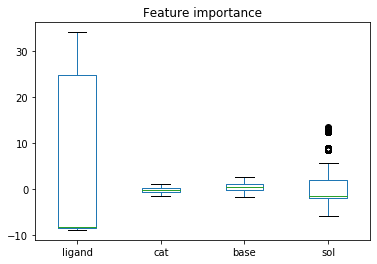

Analysing feature importance for you...


<Figure size 864x1440 with 0 Axes>

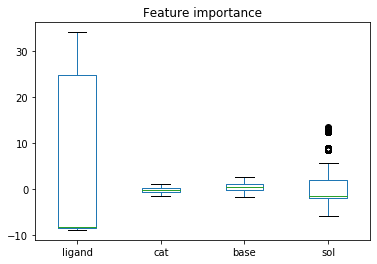


You are all set! Have a good one, mate!

End: 2019/09/18  20:29:48


In [20]:
# ALL CODE:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.externals.joblib import dump
import seaborn as sns
import time
from treeinterpreter import treeinterpreter as ti
import matplotlib.pyplot as plt

# def get_colu_num_numerical(filename1_df):#X with no label
#     colu = filename1_df.iloc[:,:-1].select_dtypes(exclude=['object']) #extract  columns
#     num = len(colu.columns) #get the number of  columns
#     return colu, num

# def get_colu_num_catagorical(filename1_df):#X with no label
#     colu = filename1_df.iloc[:,:-1].select_dtypes(include=['object']) #extract  columns
#     num = len(colu.columns) #get the number of  columns
#     return colu, num

# # find index in all_combos of train_data  
# #先在all里面加入索引，然后merge 去交际，留下交际，得到index
# def get_train_OHE(filename1_df, all_combos_df):
#     All_OHE_df = pd.get_dummies(all_combos_df) # OHE for all data
#     copy_df = all_combos_df.copy()
#     copy_df['index'] = np.arange(len(all_combos_df.iloc[:,1]))# Creat a new colum for index in all
#     X = filename1_df.iloc[:,:-1] #X
#     merge_df = pd.merge(copy_df, X, how='inner') #Merge data from unconverted formation
#     index_lst = merge_df['index'].tolist()
#     X_OHE_df = All_OHE_df.iloc[index_lst,:]
#     return X_OHE_df

# # Get the index of each catagorical data
# def get_OHE_index(filename1_df): #from your X
#     #get unique num:
#     Numerical_colu, Numerical_num = get_colu_num_numerical(filename1_df)#get the number of numerical columns, one-hot-encoded columns should appear behind them.
#     Discrete_colu, Discrete_num = get_colu_num_catagorical(filename1_df)
#     unique_num = []
#     for i in Discrete_colu.columns:
#         unique_num.append(len(Discrete_colu[i].unique()))
#     index = [Numerical_num]
#     count = Numerical_num
#     for i in unique_num[:-1]:
#         count = count + int(i)
#         index.append(count)
# #     print('Index of OHE:',index)
#     return index

#tree interpreter for feature importance
#以下是tree interpreter的集成代码
# def plot_tree(model,filename1_df, all_combos_df): #model, filename1_df is dataframe of train data. All is dataframe of allcombos.
#     X = filename1_df.iloc[:,:-1]
#     unseen = pd.concat([all_combos_df, X]).drop_duplicates(keep=False) # drop when you get index
#     prediction, bias, contributions = ti.predict(model, unseen)
#     contributions = pd.DataFrame(contributions, columns=all_combos_df.columns) #get all the contributions
#     plt.figure(figsize=(12, 20))
#     contributions.plot.box()
#     plt.title('Feature importance')
#     plt.savefig('Feature importance.png')
#     plt.show()

#load data
print('Welcome! Let me work out what is the best experiment for you to run...')
#filename1 = input("Please type in your train data file name: ")
#filename2 = input('Please type in your chemical space file name: ')
print('\nStart:', time.strftime("%Y/%m/%d  %H:%M:%S"))
filename1 = 'train_data.xlsx'
filename2 = 'all_combos.xlsx'
print('\nLoading: ', filename1)

filename1_df = pd.read_excel(filename1)
all_combos_df = pd.read_excel(filename2)
y = filename1_df.iloc[:,-1]
X = filename1_df.iloc[:,:-1]

print('\nAll good till now. I am figuring out the best method to analyze your data. Bear with me...')
#General stuff
seed = 1234
kfold = KFold(n_splits = 2, random_state = seed)#
scoring = 'neg_mean_absolute_error'
model = RandomForestRegressor(random_state=seed)

#Parameters to tune
# estimators = np.arange(100, 1050, 50) 
# estimators_int = np.ndarray.tolist(estimators)
estimators_int = [200, 500]
param_grid = {'n_estimators':estimators_int, 'max_features':['auto', 'sqrt'],
              'max_depth':[None ]}#
#search best parameters and train
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(X, y)

#print the best data cranked out from the grid search
np.savetxt('Model_best_score_MAE.txt', ["best_score: %s" % grid.best_score_], fmt ='%s')
best_params = pd.DataFrame([grid.best_params_], columns=grid.best_params_.keys())
best_params.to_csv('best_parameters.txt', sep= '\t')

print('\n... done! It is going to be lightspeed from here on out! :)')
#predict future data
unseen = pd.concat([all_combos_df, X]).drop_duplicates(keep=False) # drop when you get index
model2 = grid.best_estimator_
# model2 = RandomForestRegressor(n_estimators = grid.best_params_['n_estimators'], max_features = grid.best_params_['max_features'], max_depth = grid.best_params_['max_depth'], random_state = seed)
RF_fit = model2.fit(X, y)
predictions = model2.predict(unseen)
predictions_df = pd.DataFrame(data=predictions, columns=['Prediction'])

# #feature importance
# feat_imp = pd.DataFrame(model2.feature_importances_,
#                         index=train.iloc[:,1:-1].columns,
#                         columns=['Feature_importances'])
# feat_imp = feat_imp.sort_values(by=['Feature_importances'], ascending = False)

all_predictions = []
for e in model2.estimators_:
    all_predictions += [e.predict(unseen)]

variance = np.var(all_predictions, axis=0)
variance_df = pd.DataFrame(data=variance, columns=['Variance'])

assert len(variance) == len(predictions)
# unseen_combos_df = pd.concat([all_combos_df, X]).drop_duplicates(keep=False)
df = pd.concat([unseen, predictions_df, variance_df], axis=1)

prediction, bias, contributions = ti.predict(model2, unseen)
contributions = pd.DataFrame(contributions, columns=all_combos_df.columns) #get all the contributions
plt.figure(figsize=(12, 20))
contributions.plot.box()
plt.title('Feature importance')
plt.savefig('Feature importance.png')
plt.show()

print('Analysing feature importance for you...')
plot_tree(model2, filename1_df, all_combos_df)
#save data
df.to_csv('predictions.csv',index=False)
print('\nYou are all set! Have a good one, mate!')#all_comboss.csv
print('\nEnd:', time.strftime("%Y/%m/%d  %H:%M:%S"))#train_data.csv

In [24]:
unseen

,ligand,cat,base,sol
0,0.1,0.05,1,21
1,0.1,0.05,1,43
2,0.1,0.05,1,65
4,0.1,0.05,1,343
6,0.1,0.05,2,21
7,0.1,0.05,2,43
8,0.1,0.05,2,65
10,0.1,0.05,2,343
12,0.1,0.05,3,21
13,0.1,0.05,3,43


In [21]:
unseen.info(),all_combos_df.info(),X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378 entries, 0 to 574
Data columns (total 4 columns):
ligand    378 non-null float64
cat       378 non-null float64
base      378 non-null int64
sol       378 non-null int64
dtypes: float64(2), int64(2)
memory usage: 24.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 4 columns):
ligand    576 non-null float64
cat       576 non-null float64
base      576 non-null int64
sol       576 non-null int64
dtypes: float64(2), int64(2)
memory usage: 18.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
ligand    10 non-null float64
cat       10 non-null float64
base      10 non-null int64
sol       10 non-null int64
dtypes: float64(2), int64(2)
memory usage: 400.0 bytes


(None, None, None)

In [22]:
all_combos_df

,ligand,cat,base,sol
0,0.1,0.05,1,21
1,0.1,0.05,1,43
2,0.1,0.05,1,65
3,0.1,0.05,1,67
4,0.1,0.05,1,343
5,0.1,0.05,1,67
6,0.1,0.05,2,21
7,0.1,0.05,2,43
8,0.1,0.05,2,65
9,0.1,0.05,2,67


In [23]:
X

,ligand,cat,base,sol
0,0.2,0.03,2,67
1,0.4,0.03,2,43
2,0.2,0.03,3,67
3,0.4,0.03,1,43
4,0.4,0.05,5,343
5,0.2,0.03,6,67
6,0.2,0.08,5,43
7,0.4,0.03,2,65
8,0.2,0.03,1,67
9,0.6,0.03,3,65
